In [1]:
import os, sys
import glob as glob
import numpy as np
import logging
import mdtraj
import warnings
from pprint import pprint
from openff.qcsubmit.common_structures import QCSpec, DriverEnum, SCFProperties
from openff.qcsubmit.factories import BasicDatasetFactory
from openff.toolkit.topology import Molecule, Topology
from tqdm import tqdm

In [2]:
# check version
from openff.toolkit._version import get_versions
get_versions()

{'date': '2023-02-27T12:08:52-0800',
 'dirty': False,
 'error': None,
 'full-revisionid': 'e05c876611e40067575bda9c8c47022570e3c508',
 'version': '0.12.1'}

### Inspect molecule

In [3]:
def get_bonds(mol):
    for bond in mol.bonds:
        assert bond.bond_order <= 2
        if bond.bond_order == 2:
            print(bond.atom1.name, bond.atom2.name, bond.bond_order)

##### adenosine

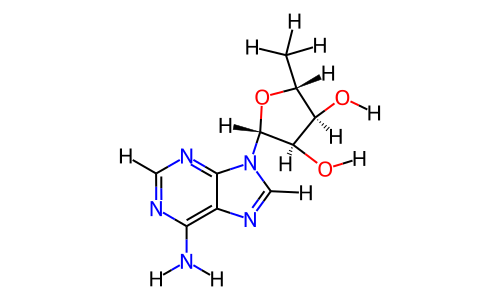

In [4]:
traj = mdtraj.load("../cluster/traj_cls_a.nc", top="../md/crd/a.pdb")
unique_molecules = Molecule.from_file("../md/crd/a.sdf")
topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
mol = Molecule.from_topology(topology)
mol.visualize()

In [5]:
mol

NGLWidget()

In [6]:
get_bonds(mol)

N1 C2 2
N3 C4 2
C5 C6 2
N7 C8 2


##### cytidine

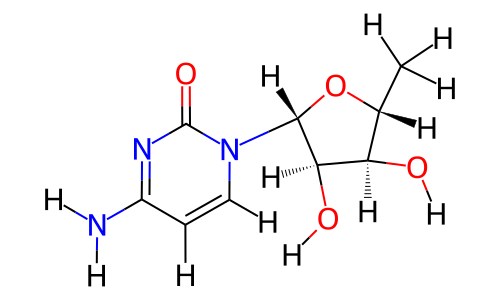

In [7]:
traj = mdtraj.load("../cluster/traj_cls_c.nc", top="../md/crd/c.pdb")
unique_molecules = Molecule.from_file("../md/crd/c.sdf")
topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
mol = Molecule.from_topology(topology)
mol.visualize()

In [8]:
mol

NGLWidget()

In [9]:
get_bonds(mol)

C2 O2 2
N3 C4 2
C5 C6 2


##### guanosine

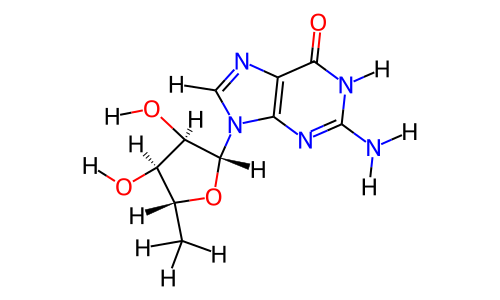

In [10]:
traj = mdtraj.load("../cluster/traj_cls_g.nc", top="../md/crd/g.pdb")
unique_molecules = Molecule.from_file("../md/crd/g.sdf")
topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
mol = Molecule.from_topology(topology)
mol.visualize()

In [11]:
mol

NGLWidget()

In [12]:
get_bonds(mol)

C2 N3 2
C4 C5 2
C6 O6 2
N7 C8 2


##### uridine

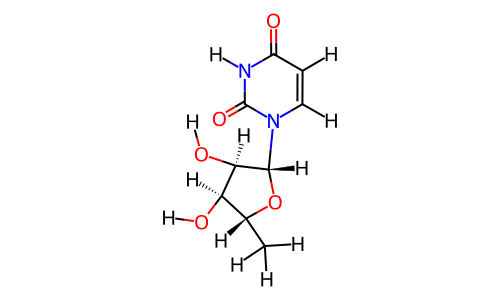

In [13]:
traj = mdtraj.load("../cluster/traj_cls_u.nc", top="../md/crd/u.pdb")
unique_molecules = Molecule.from_file("../md/crd/u.sdf")
topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
mol = Molecule.from_topology(topology)
mol.visualize()

In [14]:
mol

NGLWidget()

In [15]:
get_bonds(mol)

C2 O2 2
C4 O4 2
C5 C6 2


### Data preparation

In [16]:
files = glob.glob("../cluster/traj_cls_*.nc")

In [18]:
# convert mdtraj topology to openmm topology, and covert it to openff topology
from openmm import unit

mols = []
for file in files:
    name = file.split('/')[-1].split('.')[0][-1]
    traj = mdtraj.load(file, top=f"../md/crd/{name}.pdb")
    unique_mols = Molecule.from_file(f"../md/crd/{name}.sdf")
    
    for i in range(len(traj)):
        if i == 0:
            top = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_mols])
            mol = Molecule.from_topology(top)
        else:
            xyz = np.array(traj.openmm_positions(i)._value)
            mol.add_conformer(unit.Quantity(xyz, traj.openmm_positions(i).unit))
    mols.append(mol)

In [19]:
print(len(mols))

4


In [20]:
mols[0]

NGLWidget(max_frame=99)

In [21]:
factory = BasicDatasetFactory(
        driver=DriverEnum.gradient, 
        qc_specifications = {
            'default': QCSpec(
                method='b3lyp-d3bj', 
                basis='dzvp', 
                program='psi4', 
                spec_name='default', 
                spec_description='Standard OpenFF optimization quantum chemistry specification', 
                store_wavefunction="none", 
                implicit_solvent=None, 
                maxiter=200, 
                scf_properties=[SCFProperties.Dipole, SCFProperties.Quadrupole], 
        ), 
    }
)

In [22]:
dataset = factory.create_dataset(dataset_name="RNA Nucleoside Single Point Dataset v1.0", 
                                 molecules=mols, 
                                 tagline="QM dataset for ML", 
                                 description="This is a single point energy calculations of RNA nucleosides without the O5' hydroxyl atom. Data generation details can be at xxxx.")

Preparation                   : 100%|█████████████| 4/4 [00:05<00:00,  1.43s/it]


In [23]:
confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("Number of unique molecules       ", dataset.n_molecules)
print("Number of filtered molecules     ", dataset.n_filtered)
print("Number of conformers             ", dataset.n_records)
print("Number of conformers min mean max", confs.min(), "{:6.2f}".format(confs.mean()), confs.max())


from rdkit.Chem import Descriptors
masses = []
for molecule in dataset.molecules:
    rdmol = molecule.to_rdkit()
    mass = Descriptors.MolWt(rdmol)
    masses.append(mass)

print(f'Mean molecular weight: {np.mean(np.array(masses)):.2f}')
print(f'Max molecular weight: {np.max(np.array(masses)):.2f}')
print("Charges:", sorted(set(float(m.total_charge/m.total_charge.units) for m in dataset.molecules)))

Number of unique molecules        4
Number of filtered molecules      0
Number of conformers              400
Number of conformers min mean max 100 100.00 100
Mean molecular weight: 243.48
Max molecular weight: 267.25
Charges: [0.0]


In [24]:
dataset.metadata.submitter = 'Kenichiro Takaba'
#dataset.metadata.long_description_url = 'xxxx'

In [25]:
pprint(dataset.metadata.dict())

{'collection_type': 'DataSet',
 'creation_date': datetime.date(2023, 3, 6),
 'dataset_name': 'RNA Nucleoside Single Point Dataset v1.0',
 'elements': {'O', 'C', 'N', 'H'},
 'long_description': 'This is a single point energy calculations of RNA '
                     "nucleosides without the O5' hydroxyl atom. Data "
                     'generation details can be at xxxx.',
 'long_description_url': None,
 'short_description': 'QM dataset for ML',
 'submitter': 'Kenichiro Takaba'}


In [26]:
for spec, obj in dataset.qc_specifications.items():
    print("Spec:", spec)
    pprint(obj.dict())

Spec: default
{'basis': 'dzvp',
 'implicit_solvent': None,
 'keywords': None,
 'maxiter': 200,
 'method': 'b3lyp-d3bj',
 'program': 'psi4',
 'scf_properties': ['dipole', 'quadrupole'],
 'spec_description': 'Standard OpenFF optimization quantum chemistry '
                     'specification',
 'spec_name': 'default',
 'store_wavefunction': 'none'}


In [27]:
pprint(dataset.qc_specifications)

{'default': QCSpec(method='b3lyp-d3bj', basis='dzvp', program='psi4', spec_name='default', spec_description='Standard OpenFF optimization quantum chemistry specification', store_wavefunction=<WavefunctionProtocolEnum.none: 'none'>, implicit_solvent=None, maxiter=200, scf_properties=[<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>], keywords=None)}


#### Export the dataset

In [28]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file("dataset.smi", "smi")

In [34]:
try:
    dataset.visualize('dataset.pdf')
except:
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import IPythonConsole
    #IPythonConsole.drawOptions.minFontSize=12

    rdmols = [ mol.to_rdkit() for mol in mols ]
    img = Draw.MolsToGridImage(rdmols, molsPerRow=5, subImgSize=(500,500), returnPNG=False, maxMols=99999)
    img = img.convert('RGB')
    img.save("dataset.pdf")